# Sibur challenge

<a href=https://sibur.ai-community.com/competitions/4/tasks/11>Соревнование по прогнозу состава сырья.</a> Всю необходимую информацию можете найти на сайте соревнования.

Вкратце, необходимо построить прогноз состава поступающей по трубопроводу ШФЛУ (широкая фракция легких углеводородов) на основании данных с последней перед потребителем станции подкачки.

**Данные** содержат расходы сырья в т/ч для станции подкачки A (**A_rate**) и потребителя B (**B_rate**), а также массовые процентные доли различных компонент на станции A (**A_CH4, A_C2H6, A_C3H8, A_iC4H10, A_nC4H10, A_iC5H12, A_nC5H12, A_C6H14**).

**Целевые переменные:** массовые процентные доли нескольких компонент на станции B (**B_C2H6, B_C3H8, B_iC4H10, B_nC4H10**).

## 0. Imports and requirements

In [3]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# pd.options.plotting.backend = "plotly"
%matplotlib inline

In [4]:
train_targets = pd.read_csv("train_targets.csv", index_col = 0)
train_features = pd.read_csv("train_features.csv", index_col = 0)
sample = pd.read_csv("sample_submission.csv")
test_features = pd.read_csv("test_features.csv", index_col = 0)

## 1. EDA

Для начала посмотрим какие данные мы имеем. (**train_features**)

In [5]:
train_features.head()

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
timestamp,,,,,,,,,,
2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789
2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098
2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409
2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126
2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921


In [6]:
train_targets.head()

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
timestamp,,,,
2020-01-01 00:00:00,4.561979,39.015486,17.250740,24.301793
2020-01-01 00:30:00,4.550741,39.048915,17.229506,24.257461
2020-01-01 01:00:00,4.506793,38.766378,17.171621,24.236298
2020-01-01 01:30:00,4.584963,39.069360,17.218521,24.149843
2020-01-01 02:00:00,4.607483,38.817579,17.108668,24.049510


Временной ряд с шагов 30 минут. Так как весь датасет это состав сырья, следовательно сумма всех компонентов должна давать 100%.

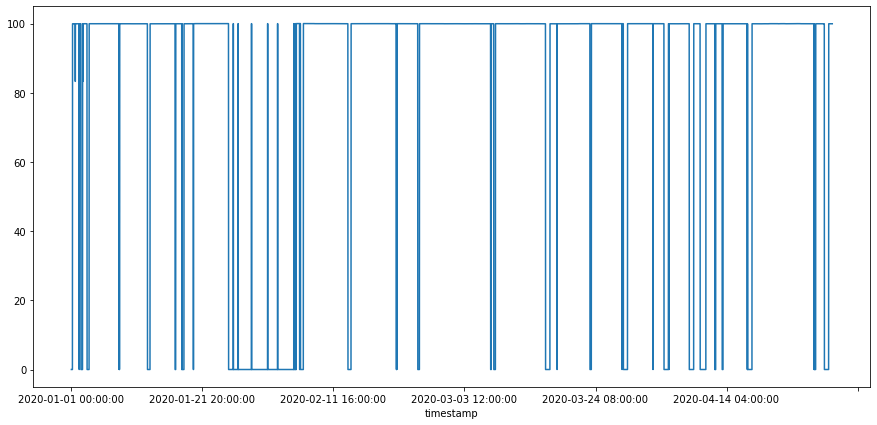

In [12]:
train_features.iloc[:,1:-1].sum(axis = 1).plot(figsize=(15,7));

Сразу можем заметить, что у нас много пропущенных значений. Построим временные отрезки по всем переменным.

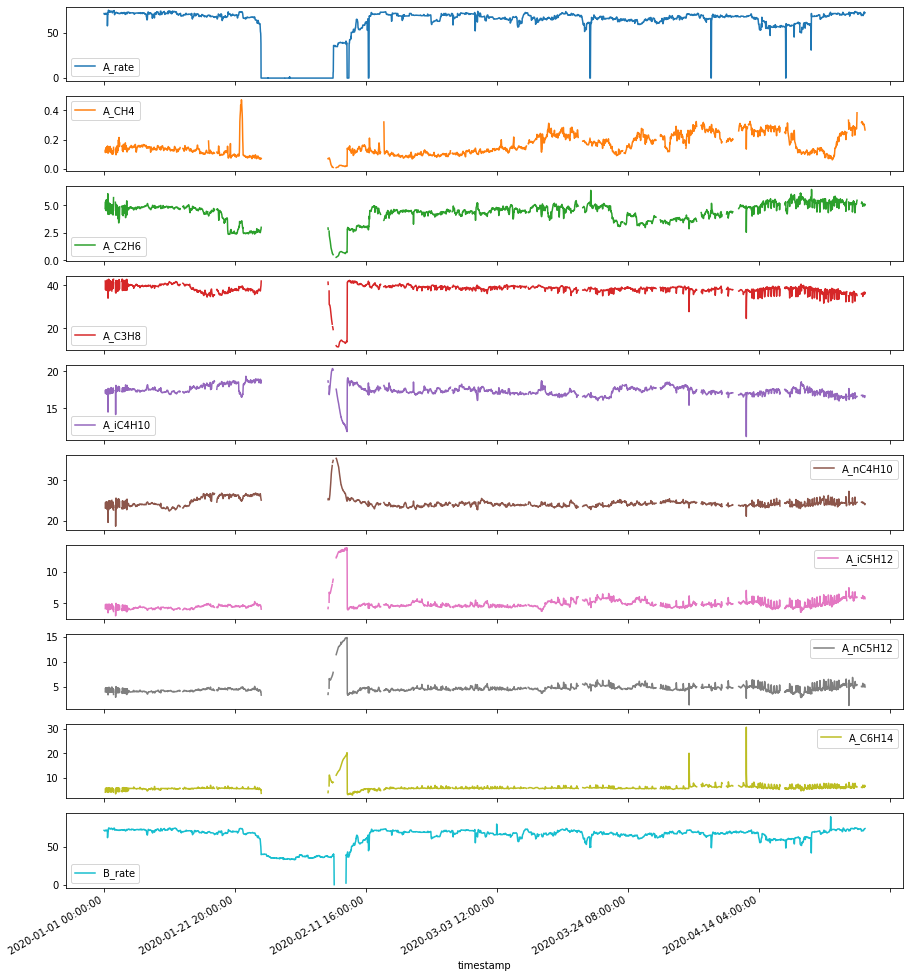

In [13]:
# pd.options.plotting.backend = "matplotlib"
train_features.plot(subplots = True, figsize = (15,18));

Как можно заметить, у нас очень длительный отрезок пропущенных значений. В добавок, в тех временных промежутках, где имеются пропущенные значения, очень сильно проседают *A_rate* и *B_rate*. 

Аналогичная ситуация и для **тестовой выборки**.

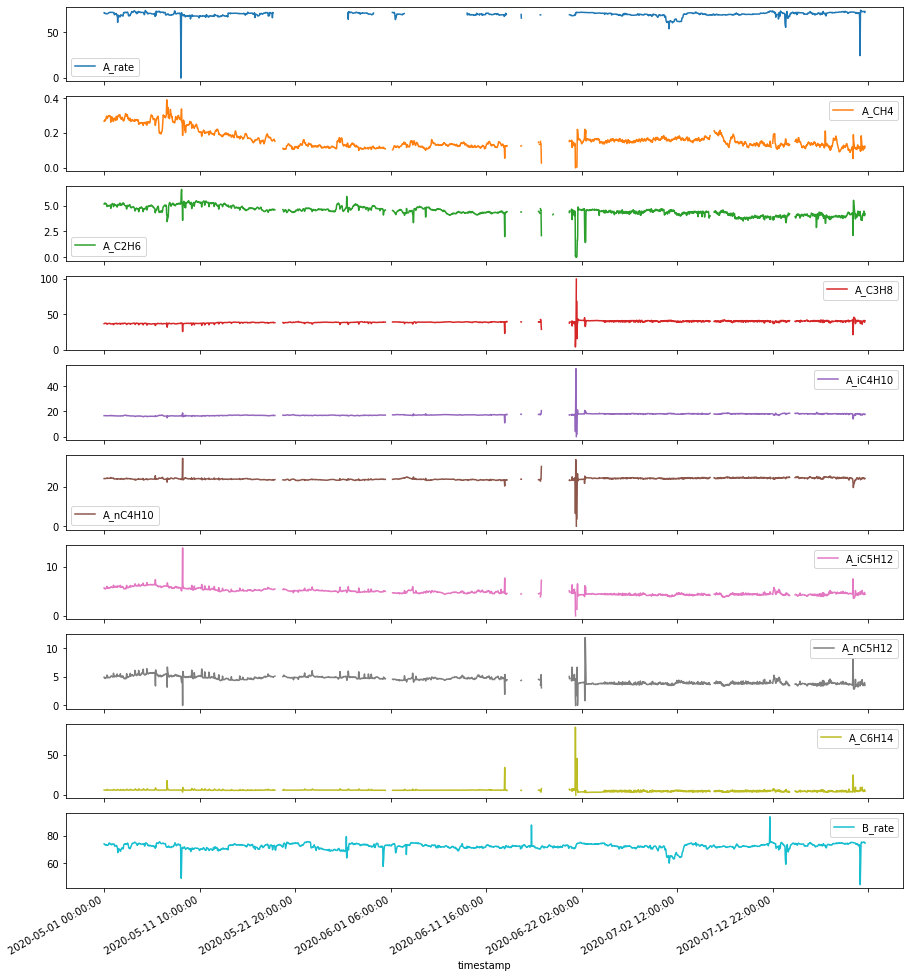

In [14]:
test_features.plot(subplots = True, figsize = (15,18));

In [15]:
def missing_percent(df):
    missing_counts = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()*100/df.shape[0]).sort_values(ascending = False)

    missing_df = pd.concat([missing_counts, percent], axis = 1, keys = ['Counts', '%'])
    return display(missing_df.head().style.background_gradient(cmap = 'Reds', axis = 0))

missing_percent(train_features)

,Counts,%
A_C6H14,959,16.511708
A_nC5H12,959,16.511708
A_iC5H12,959,16.511708
A_nC4H10,959,16.511708
A_iC4H10,959,16.511708


In [16]:
missing_percent(test_features)

,Counts,%
A_rate,1142,28.664659
A_nC5H12,456,11.445783
A_iC5H12,456,11.445783
A_CH4,456,11.445783
A_C6H14,455,11.420683


Переменные цели - **train_targets**.

In [17]:
train_targets.head()

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
timestamp,,,,
2020-01-01 00:00:00,4.561979,39.015486,17.250740,24.301793
2020-01-01 00:30:00,4.550741,39.048915,17.229506,24.257461
2020-01-01 01:00:00,4.506793,38.766378,17.171621,24.236298
2020-01-01 01:30:00,4.584963,39.069360,17.218521,24.149843
2020-01-01 02:00:00,4.607483,38.817579,17.108668,24.049510


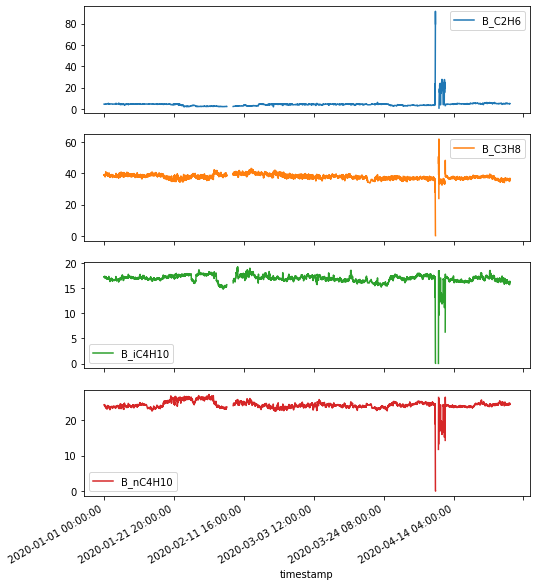

In [19]:
train_targets.plot(subplots = True, figsize = (8, 10));

In [20]:
missing_percent(train_targets)

,Counts,%
B_C2H6,184,3.168044
B_nC4H10,180,3.099174
B_iC4H10,180,3.099174
B_C3H8,180,3.099174


Пропущенные значения также имеются и у переменных цели. 

## 2. Data prepocessing and data generation

По правилам турнира мы не можем использовать данные из будущего. К примеру запрещен метод заполнения пропусков **backward fill** и **interpolate**, однако не уверен, что это касается обучающей выборки. Как бы то ни было, пропуски я заполнял **по усредненным значениям последних 20 наблюдений**. Метод **forward fill** не подходил, так как в тех местах, где разрыв в данных начинается после скачка, данный метод не логичен.

In [21]:
def rolling_mean_imputing(df, rolling):
    df_cleaned = df.reset_index(drop = True)
    for i in df_cleaned:
        for n in df_cleaned.index:
            if str(df_cleaned.loc[n, i]) == 'nan':
                df_cleaned.loc[n, i] = df_cleaned[i][n-rolling:n].mean()
            else:
                pass
    return df_cleaned

In [22]:
# pd.options.plotting.backend = "plotly"
train_features_cleaned = rolling_mean_imputing(train_features, 20)
train_targets_cleaned = rolling_mean_imputing(train_targets, 20)

В обучающей выборке у нас не было пропусков в A_rate и B_rate, в то время как в тестовой есть много пропусков в A_rate. Из графиков видно, что эти переменные сильно коррелируют, поэтому буду заполнять пропуски A_rate, используя значение B-rate.

In [23]:
for i in test_features['A_rate'].index:
    if str(test_features['A_rate'][i]) == 'nan':
        test_features.loc[i, 'A_rate'] = test_features.loc[i, 'B_rate'] - (test_features['B_rate'] - test_features['A_rate']).mean()

test_features_cleaned = rolling_mean_imputing(test_features, 20)

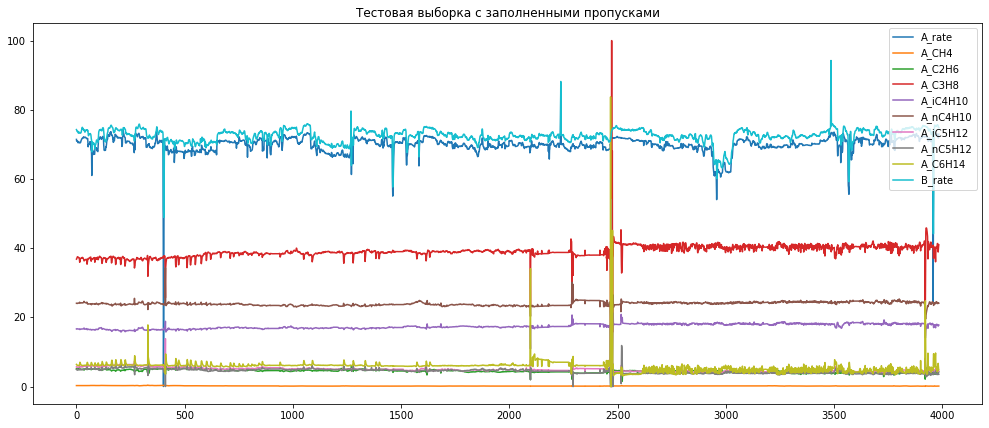

In [32]:
test_features_cleaned.iloc[:, :10].plot(title = "Тестовая выборка c заполненными пропусками",
                                       figsize = (17,7));

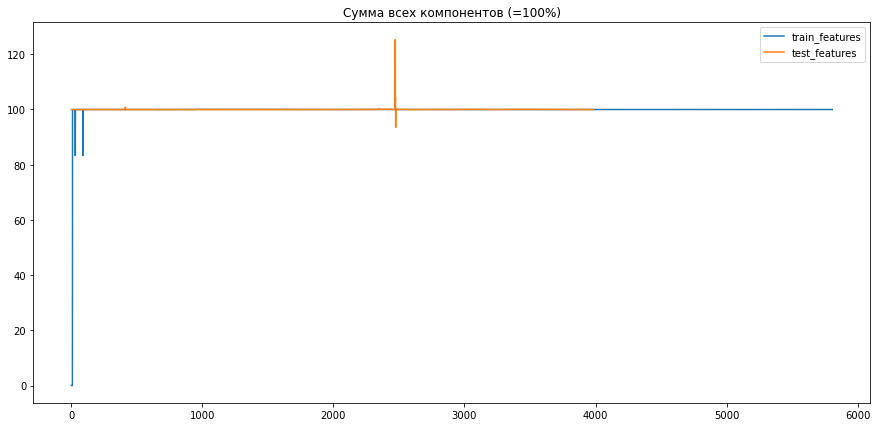

In [35]:
pd.DataFrame({'train_features': train_features_cleaned.iloc[:,1:-1].sum(axis = 1),
             'test_features': test_features_cleaned.iloc[:,1:-1].sum(axis = 1)}).plot(title = "Сумма всех компонентов (=100%)",
                                                                                     figsize = (15,7));

В начале тренировочной выборки остались пропущенные значения, так как для них нет данных по 20 предыдущим значениям. Удалим их. А с 2-мя наблюдениями, у которых сумма компонентов !=100%, предпримим ничего... 2 наблюдения не сыграют никакой роли. 

Во временных рядам полезно генерировать данные, которые могут еще больше описать временной ряд. А именно, можно добавить скользящие средние, максимумы, минимумы, отклонения и тд. Оптимальное количество пред. значений для посчета новых переменных начинается со 100. Меньшее окно вносило гораздо меньше вклада в модель. 

In [36]:
def data_generating(df):
    window_sizes = [100, 200, 300]
    # window_sizes = [3, 5, 7, 10, 20, 50]
    columns = df.columns
    for window in window_sizes:
        for col in columns:
            df["rolling_mean_" + col + str(window)] = df[col].rolling(window=window).mean()
            df["rolling_std_" + col + str(window)]  = df[col].rolling(window=window).std()
            df["rolling_var_" + col + str(window)]  = df[col].rolling(window=window).var()
            df["rolling_min_" + col + str(window)]  = df[col].rolling(window=window).min()
            df["rolling_max_" + col + str(window)]  = df[col].rolling(window=window).max()
            df["rolling_kurt_" + col + str(window)]  = df[col].rolling(window=window).kurt()
            df["rolling_sum_" + col + str(window)]  = df[col].rolling(window=window).sum()
            df["rolling_skew_" + col + str(window)]  = df[col].rolling(window=window).skew()
            df["rolling_min_max_ratio_" + col + str(window)] = df["rolling_min_"+ col + str(window)] / df["rolling_max_" + col + str(window)]
            df["rolling_min_max_diff_" + col + str(window)]  = df["rolling_max_"+ col + str(window)] - df["rolling_min_" + col + str(window)]

            a = (df[col] - df['rolling_min_'+ col + str(window)]) / (df['rolling_max_'+ col + str(window)] - df['rolling_min_' + col + str(window)])
            df["norm_" + col + str(window)] = a * (np.floor(df['rolling_max_' + col + str(window)]) - np.ceil(df['rolling_min_' + col + str(window)]))

    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    
    return df

train = data_generating(train_features_cleaned)
test = data_generating(test_features_cleaned)

## 3. Catboost

В качестве алгоритма я использовал CatBoost, так как он устойчив к выбросам и сам подбирает оптимальные параметры. CatBoost — открытая программная библиотека, разработанная компанией Яндекс и реализующая уникальный патентованный алгоритм построения моделей машинного обучения, использующий одну из оригинальных схем градиентного бустинга. 

Также использовал кросс-валидацию на 5 фолдах, чтобы учесть проблему переобучения.

In [37]:
train = train.iloc[9:, :].reset_index(drop = True)

nfolds = 5
groups = np.array(train.A_rate.values)
folds = GroupKFold(n_splits = 5)

In [38]:
tr = []
pred = []
feature_importance_df = np.zeros((train.shape[1], nfolds))

for col in train_targets_cleaned.columns:
    print('-----------------' + '\n' + col)
    y = train_targets_cleaned[col].iloc[9:]
    y = y.reset_index(drop = True)
    train = train.reset_index(drop = True)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train.values, groups)):
        print('----')
        print("fold n°{}".format(fold_))

        x0,y0 = train.iloc[trn_idx], y[trn_idx]
        x1,y1 = train.iloc[val_idx], y[val_idx]

        print(y0.size, y1.size)

        pd.DataFrame(y1).to_csv('y_test_fold' + str(fold_) + '.csv', index=False)

        model = CatBoostRegressor(iterations=600, #2000
    #                                   learning_rate=0.1,
    #                                   depth=4,
                                  loss_function="MAPE")

        model.fit(x0, y0, eval_set=(x1, y1), verbose_eval=200)#, plot = True)

        feature_importance_df[:, fold_] = model.feature_importances_
        tr.append(model.predict(train))
        pred.append(model.predict(test))

-----------------
B_C2H6
----
fold n°0
4639 1160
0:	learn: 0.2099674	test: 0.2224009	best: 0.2224009 (0)	total: 127ms	remaining: 1m 15s
200:	learn: 0.0462770	test: 0.0541174	best: 0.0541174 (200)	total: 8.15s	remaining: 16.2s
400:	learn: 0.0398869	test: 0.0475465	best: 0.0475465 (400)	total: 16.1s	remaining: 7.97s
599:	learn: 0.0359402	test: 0.0445919	best: 0.0445919 (599)	total: 24.4s	remaining: 0us

bestTest = 0.04459187611
bestIteration = 599

----
fold n°1
4639 1160
0:	learn: 0.2133937	test: 0.2089548	best: 0.2089548 (0)	total: 46.3ms	remaining: 27.8s
200:	learn: 0.0484847	test: 0.0458238	best: 0.0458238 (200)	total: 9.04s	remaining: 17.9s
400:	learn: 0.0413971	test: 0.0398910	best: 0.0398910 (400)	total: 18.9s	remaining: 9.4s
599:	learn: 0.0378297	test: 0.0377581	best: 0.0377581 (599)	total: 29.1s	remaining: 0us

bestTest = 0.03775812041
bestIteration = 599

----
fold n°2
4639 1160
0:	learn: 0.2109051	test: 0.2185878	best: 0.2185878 (0)	total: 60ms	remaining: 36s
200:	learn: 0.046

599:	learn: 0.0127811	test: 0.0302403	best: 0.0302403 (599)	total: 32.4s	remaining: 0us

bestTest = 0.03024032919
bestIteration = 599

----
fold n°4
4640 1159
0:	learn: 0.0647330	test: 0.1147079	best: 0.1147079 (0)	total: 69.5ms	remaining: 41.7s
200:	learn: 0.0153989	test: 0.0525592	best: 0.0525527 (199)	total: 10.5s	remaining: 20.8s
400:	learn: 0.0105870	test: 0.0501565	best: 0.0501565 (400)	total: 21.2s	remaining: 10.5s
599:	learn: 0.0101521	test: 0.0498243	best: 0.0498243 (599)	total: 31.3s	remaining: 0us

bestTest = 0.04982431645
bestIteration = 599



Видим, что ошибка на валидации хорошая для каждого таргета и дисперсия ошибок(потерь) мала.

Оптимальное количество итераций примерно 600, дальше идет переобучение. Касательно остальных параметров (learning_rate, глубина дерева и т.д.), подобранные мною параметры давали результат хуже, чем выбранные самим CatBoost'ом.

Посмотрим какие переменные вложили больший вклад в модель, к примеру для target'a B_nC4H10.

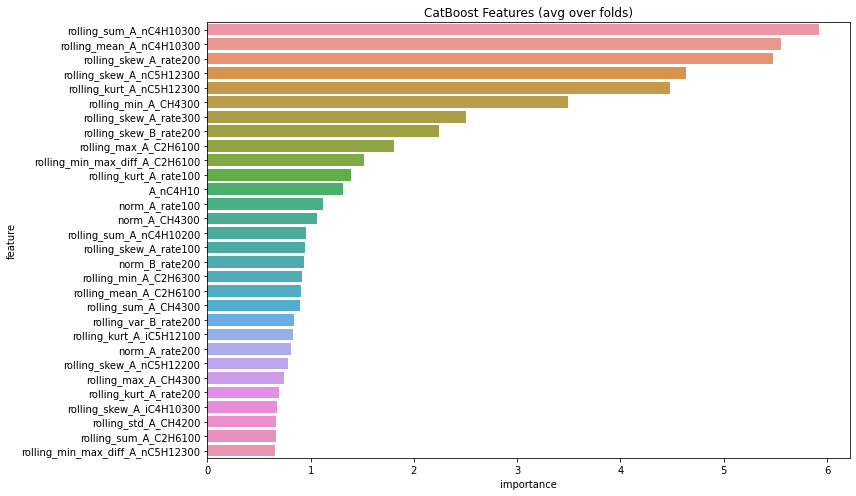

In [45]:
ximp = pd.DataFrame()
ximp['feature'] = train.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)

plt.figure(figsize=(12,7))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                           ascending=False).head(30))
plt.title('CatBoost Features (avg over folds)')
plt.tight_layout()

Видим, что сгенерированные данные вносят большой вклад.

Данное решение я выбрал в качестве окончательного на соревновании. Были и другие решения, которые показали чуть более лучший скор. (Среди моих решений, данное решение **catboost + rolling_features** занимает 5 место)

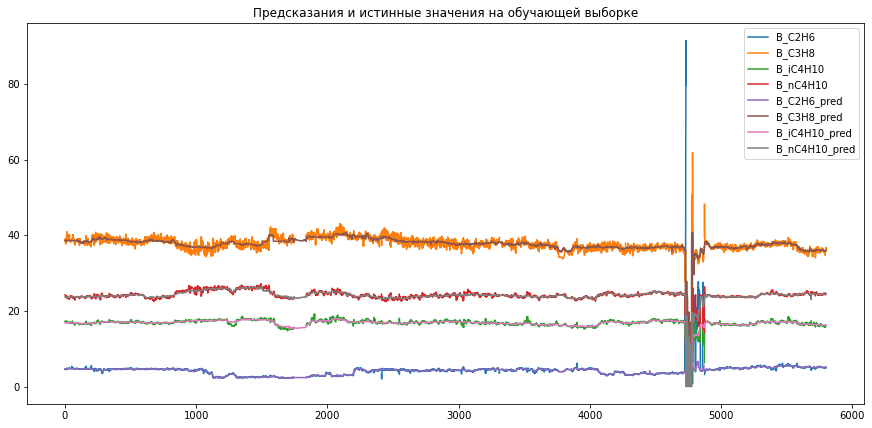

In [46]:
train_targets.iloc[9:,:].reset_index(drop=True).join(pd.DataFrame(tr[1::5]).T.rename(
    columns={0:'B_C2H6_pred',1:'B_C3H8_pred',2:'B_iC4H10_pred',3:'B_nC4H10_pred'})).plot(title = 'Предсказания и истинные значения на обучающей выборке',
                                                                                        figsize = (15, 7));

## 4. Что не было включено в окончательное решение и результаты

* **Нормальзация данных** никак не повлияла на скор.
* Вместо генерации rolling_features, я использовал **шифты**, то есть истинные значения предыдущих периодов. Отказался от данного решения, так как показал немного меньший скор, а зря. (Теоретически мог улучшить свою позицию в лидерборде)
* Так как модель сглаживала предсказания, я использовал **другие метрики** для оценки модели, но результаты получились крайне плохими.

Метрика - **MAPE**

| Модель | Публичный лидерборд | Приватный лидерборд | Место |
| --- | --- | --- |  --- |
| catboost + rolling_features | 2.9197 | 3.8742 | 91/206 |
| catboost + shifts | 2.9285 | 3.5413 | 58/206 |
| скор победителя | 1.69... | 2.5639 | 1/206 |